### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import norm
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Data

In [2]:
train_data = pd.read_csv('/kaggle/input/allstate-claims-severity/train.csv')
test_data = pd.read_csv('/kaggle/input/allstate-claims-severity/test.csv')
train_data.shape

(188318, 132)

In [3]:
train_data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [5]:
train_data.dtypes

id          int64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object

In [6]:
train_data.isnull().mean()

id        0.0
cat1      0.0
cat2      0.0
cat3      0.0
cat4      0.0
         ... 
cont11    0.0
cont12    0.0
cont13    0.0
cont14    0.0
loss      0.0
Length: 132, dtype: float64

### Distribution of target variable

<AxesSubplot: xlabel='loss', ylabel='Count'>

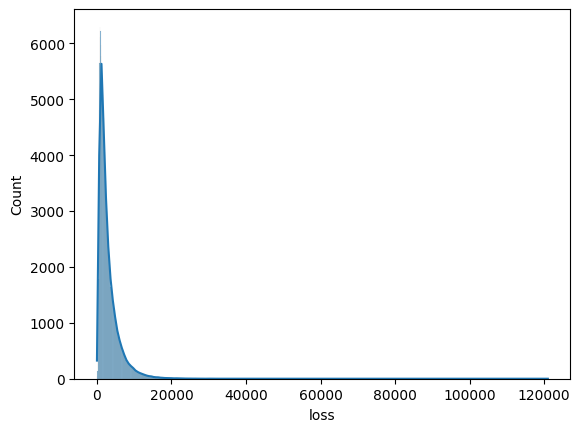

In [7]:
sns.histplot(train_data['loss'], kde=True)

<AxesSubplot: xlabel='loss', ylabel='Count'>

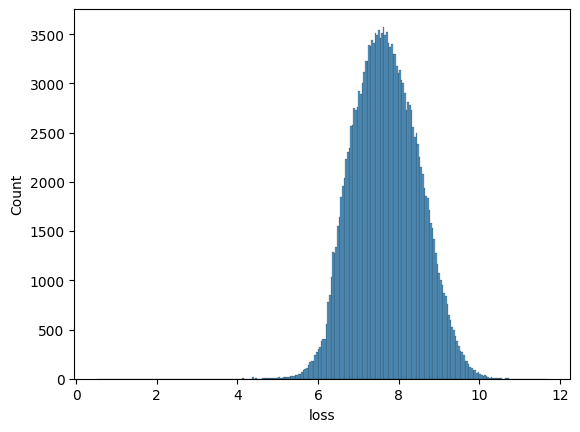

In [8]:
sns.histplot(np.log(train_data['loss']+1))

### Data Preprocessing

In [9]:
def preprocess_data(train_data, test_data):
    # Drop loss values that exceed 20000
    train_data = train_data.drop(train_data.loc[train_data['loss']>20000].index)

    # Seperate the target variable from the features in the train dataset
    y_train = train_data['loss']
    X_train = train_data.drop(['id', 'loss'], axis=1)

    # Drop the id from the test dataset 
    X_test = test_data.drop('id', axis=1)

    # Log transform target variable
    y_train = np.log(y_train + 1)

    # Define categorical and continous features
    cat_feats = [feat for feat in X_train.columns if 'cat' in feat]
    cont_feats = [feat for feat in X_train.columns if 'cont' in feat]

    # Define the preprocessing steps for categorical and continous features
    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    cont_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, cat_feats),
            ('cont', cont_transformer, cont_feats)
        ]
    )

    # Preprocess train data
    X_train = preprocessor.fit_transform(X_train)

    # Split the train dataset into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Preprocess test data
    X_test = preprocessor.transform(X_test)

    return X_train, X_val, y_train, y_val, X_test


In [10]:
# Preprocess data
X_train, X_val, y_train, y_val, X_test = preprocess_data(train_data, test_data)

### Model Experimentation

In [11]:
# Base xgboost
# Define base model
base_xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the base model to the train data
base_xgb_model.fit(X_train, y_train)

# Make prediction on validation set
predictions = base_xgb_model.predict(X_val)

# Calculate MAE on validation set
mae = mean_absolute_error(y_val, predictions)
print("Validation MAE of Base XGBoost Model: ", mae)


Validation MAE of Base XGBoost Model:  0.4193072009285199


In [12]:
# Base lgbm
# Define base model
base_lgbm_model = LGBMRegressor(random_state=42)

# Fit the base model to the train data
base_lgbm_model.fit(X_train, y_train)

# Make prediction on validation set
predictions = base_lgbm_model.predict(X_val)

# Calculate MAE on validation set
mae = mean_absolute_error(y_val, predictions)
print("Validation MAE of Base LGBM Model: ", mae)


Validation MAE of Base LGBM Model:  0.41669943019821054


### Hyperparameter Tuning

In [ ]:
# Base xgboost
# Define base model
base_xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': np.arange(0.05, 0.3, 0.05),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# Perform hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(base_xgb_model,
                                 param_distributions=param_grid,
                                 n_iter=10,
                                 cv=5, 
                                 scoring='neg_mean_absolute_error',
                                 random_state=42,
                                 n_jobs=-1)
random_search.fit(X_train, y_train)

In [ ]:
# Evaluate the best model on the validation set
best_model_xgb = random_search.best_estimator_
predictions = best_model_xgb.predict(X_val)
print(f'The final MAE is {mean_absolute_error(y_val, predictions)}')

In [ ]:
# Base lgbm
# Define base model
base_lgbm_model = LGBMRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': np.arange(0.05, 0.3, 0.05),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# Perform hyperparameter tuning using RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(base_lgbm_model,
                                 param_distributions=param_grid,
                                 n_iter=10,
                                 cv=5, 
                                 scoring='neg_mean_absolute_error',
                                 random_state=42,
                                 n_jobs=-1)
random_search_lgbm.fit(X_train, y_train)

In [ ]:
# Evaluate the best model on the validation set
best_model_lgbm = random_search_lgbm.best_estimator_
predictions = best_model_lgbm.predict(X_val)
print(f'The final MAE is {mean_absolute_error(y_val, predictions)}')

In [ ]:
submission = pd.read_csv('/kaggle/input/allstate-claims-severity/sample_submission.csv')
test_predictions = best_model_lgbm.predict(X_test)
test_predictions=np.exp(test_predictions)-1
submission['loss'] = test_predictions
submission.to_csv('submission.csv')
submission.head()